In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [2]:
df_ee = pd.read_csv('EE.csv')
llm_column = df_ee.columns[1]
emotion_columns = df_ee.columns[2:]

In [3]:
# Order emotions from negative to positive
emotion_order = [
    'Bored', 'Dull', 'Monotonous', 'Muddled', 'Irritated', 'Dissatisfied', 'Frustrated',
    'Nervous', 'Anxious', 'Worried', 'Puzzled', 'Confused', 'Surprised', 'Joyful',
    'Astonished', 'Excited', 'Amazed', 'Happy', 'Inquisitive', 'Interested', 'Curious'
]

In [4]:
# Compute Means per LLM Type
mean_df = df_ee.groupby(llm_column)[emotion_columns].mean().reset_index()

# Folder to save the  bar charts
output_dir = 'emotion_bar_charts'   


# Create the directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

In [5]:
# Plot bar charts per emotion
sns.set(style='whitegrid', palette='Set2')

for emotion in emotion_columns:
    plt.figure(figsize=(8, 5))
    sns.barplot(x=llm_column, y=emotion, data=mean_df)
    
    plt.title(f"Average '{emotion}' Intensity")
    plt.ylabel("Mean Likert Score")
    plt.ylim(0, 5)
    plt.xlabel("LLM Tutoring Style")
    plt.xticks(rotation=45)
    plt.tight_layout()

    # # Save figure
    plt.savefig(os.path.join(output_dir, f"{emotion}_bar_chart.png"))
    plt.close()

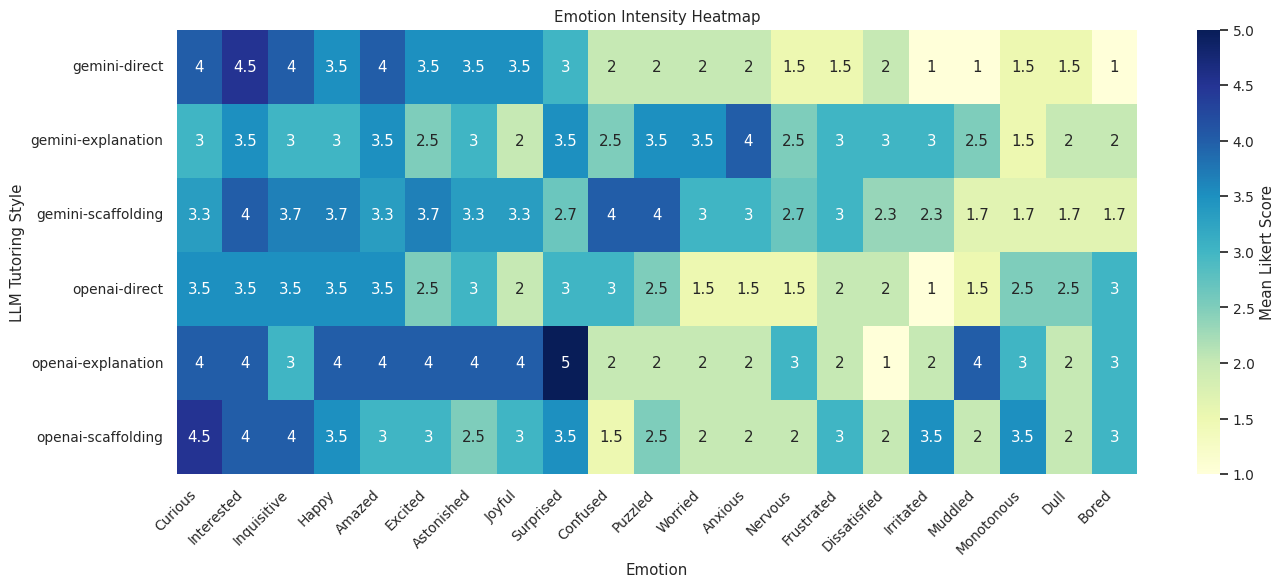

In [6]:
# Heatmap of emotions with custom order without modifying the original DataFrame
plt.figure(figsize=(14, 6))
sns.set(font_scale=0.9)

# Reorder the columns for the heatmap using reindex
ordered_df = mean_df[emotion_order + [col for col in mean_df.columns if col not in emotion_order]]

# Plot the heatmap with reordered emotions
sns.heatmap(ordered_df.set_index(llm_column), annot=True, cmap="YlGnBu", vmin=1, vmax=5,
            cbar_kws={'label': 'Mean Likert Score'})

# Reverse the x-axis to display emotions from positive to negative
plt.gca().invert_xaxis()

plt.title("Emotion Intensity Heatmap")
plt.ylabel("LLM Tutoring Style")
plt.xlabel("Emotion")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Save heatmap
plt.savefig('emotion_heatmap.png', dpi=300)
plt.show()


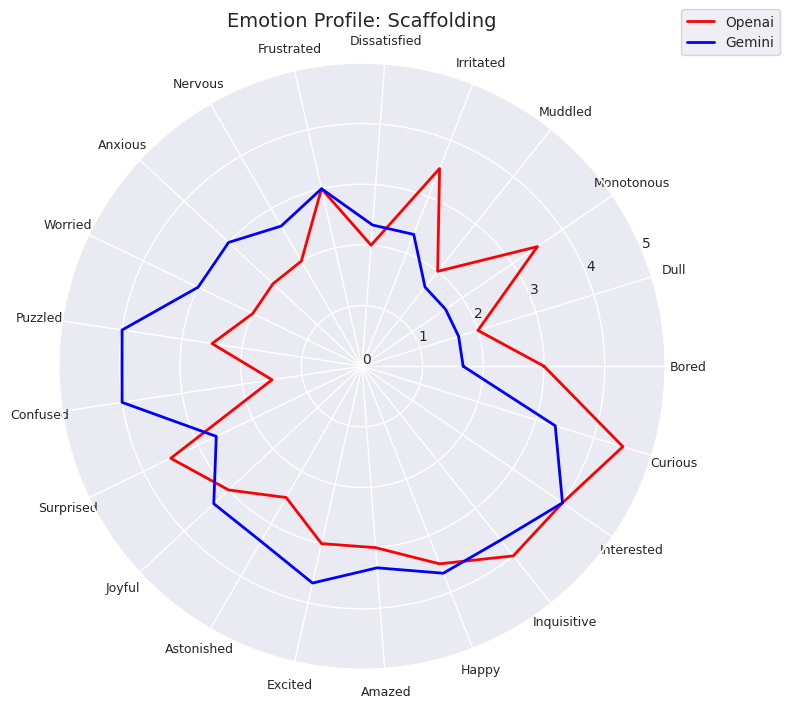

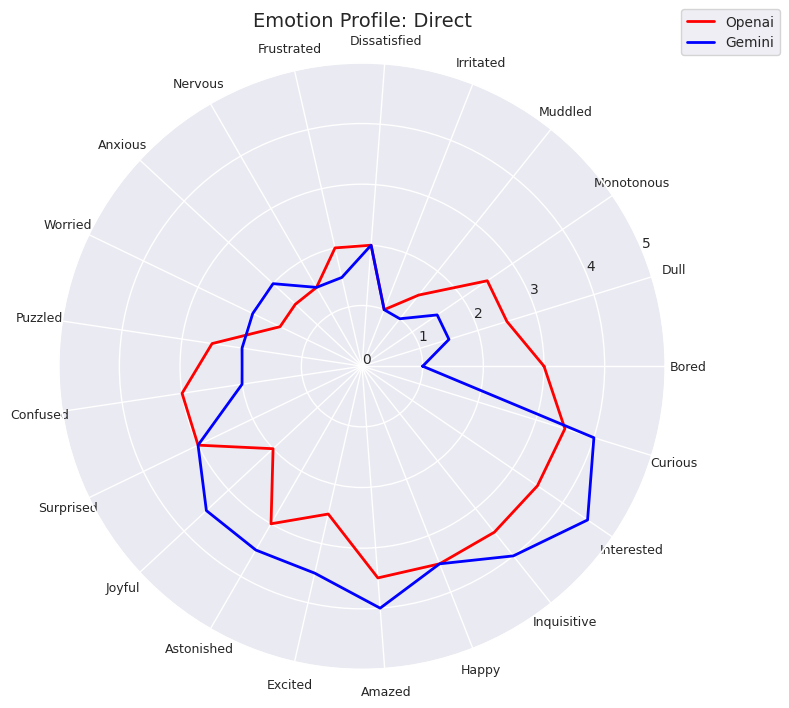

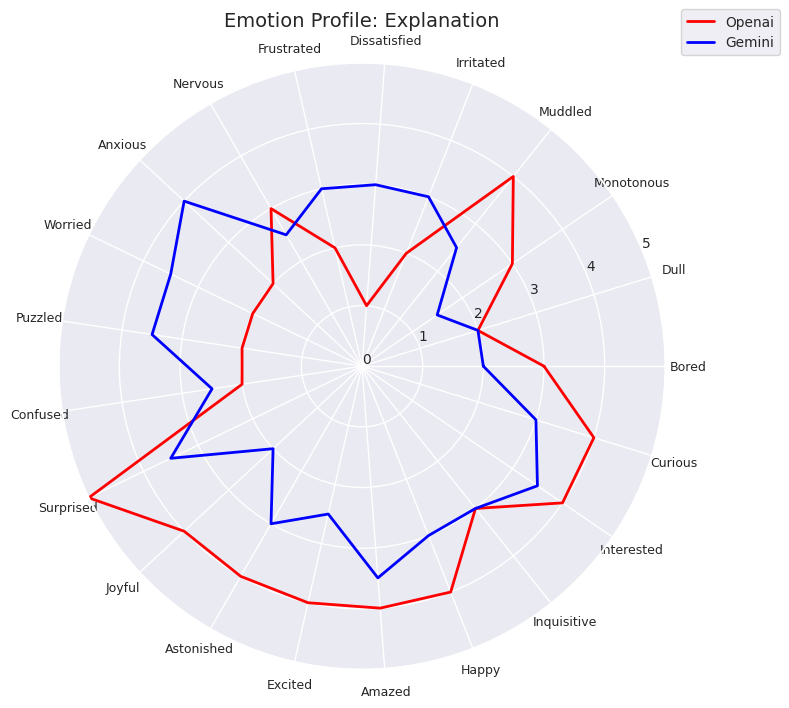

In [7]:
# Spider charts for each tutoring style
emotion_spider_charts = 'emotion_spider_charts'
os.makedirs(emotion_spider_charts, exist_ok=True)

# Emotion labels sorted by emotion_order
labels = emotion_order  # Use emotion_order here
num_vars = len(labels)
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]  # to close the circle

# Define styles and colors
styles = ['scaffolding', 'direct', 'explanation']
colors = {'openai': 'red', 'gemini': 'blue'}

for style in styles:
    plt.figure(figsize=(8, 8))
    ax = plt.subplot(111, polar=True)

    for platform in ['openai', 'gemini']:
        label_full = f"{platform}-{style}"
        row = mean_df[mean_df[llm_column] == label_full]

        if not row.empty:
            # Reorder the values based on emotion_order
            values = row.iloc[0][emotion_order].tolist()  # Use emotion_order here
            values += values[:1]  # close the radar circle

            ax.plot(angles, values, linewidth=2, linestyle='solid',
                    label=platform.capitalize(), color=colors[platform])

    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(labels, fontsize=9)  # Set the labels to emotion_order
    ax.set_yticks([0, 1, 2, 3, 4, 5])
    ax.set_ylim(0, 5)
    ax.set_title(f"Emotion Profile: {style.capitalize()}", size=14)
    ax.legend(loc='upper right', bbox_to_anchor=(1.2, 1.1))
    plt.tight_layout()

    # Save chart
    filename = f"{style}_radar.png"
    plt.savefig(os.path.join(emotion_spider_charts, filename), dpi=300)
    plt.show()

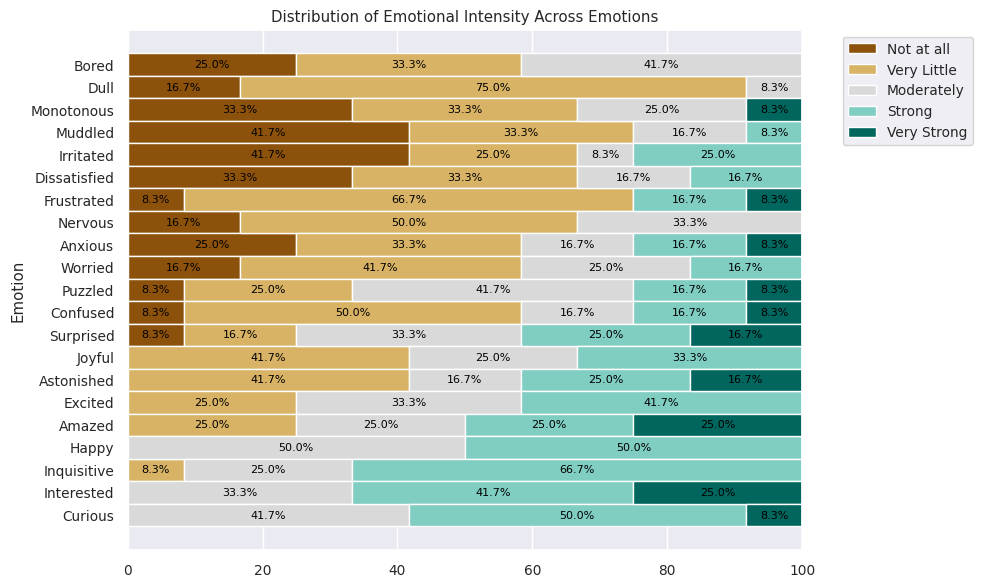

In [8]:
# Likert scale distribution plot

likert_categories = ['Not at all', 'Very Little', 'Moderately', 'Strong', 'Very Strong']
likert_colors = ['#8c510a', '#d8b365', '#d9d9d9', '#80cdc1', '#01665e']

df_long = df_ee.melt(id_vars=llm_column, value_vars=emotion_columns,
                     var_name='Emotion', value_name='Rating')

# map numeric values to labels
rating_map = {1: 'Not at all', 2: 'Very Little', 3: 'Moderately', 4: 'Strong', 5: 'Very Strong'}
df_long['Rating'] = df_long['Rating'].map(rating_map)

# Calculate percentage of responses for each emotion-rating combination
likert_dist = df_long.groupby(['Emotion', 'Rating']).size().unstack(fill_value=0)
likert_dist = likert_dist[likert_categories]  # Ensure correct order
likert_percent = likert_dist.div(likert_dist.sum(axis=1), axis=0) * 100

# to sort emotions from negative to positive
likert_percent = likert_percent.reindex(emotion_order)

# Plot
fig, ax = plt.subplots(figsize=(10, 6))
bottom = pd.Series([0] * len(likert_percent), index=likert_percent.index)

for category, color in zip(likert_categories, likert_colors):
    values = likert_percent[category]
    
    bars = ax.barh(likert_percent.index, values, left=bottom, 
                   label=category, color=color, height=1.0)

    # Add text labels centered in each segment if wide enough
    for bar, value in zip(bars, values):
        if value >= 5:  # Optional: only show if the segment is wide enough
            ax.text(bar.get_x() + bar.get_width() / 2,
                    bar.get_y() + bar.get_height() / 2,
                    f'{value:.1f}%', ha='center', va='center', fontsize=8, color='black')
    
    bottom += values

ax.set_ylabel('Emotion')
ax.set_title('Distribution of Emotional Intensity Across Emotions')
ax.legend(title='', bbox_to_anchor=(1.05, 1), loc='upper left')
ax.invert_yaxis()
plt.tight_layout()

# Save distribution plot
plt.savefig('emotion_distribution.png', dpi=300)
plt.show()